In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("yarn").appName("mypyspark").getOrCreate()

import pandas as pd

### 데이터 불러오기

In [2]:
ProductFilePath = "hdfs:///user/s21410784/finance/01.Product.csv"
Search1FilePath = "hdfs:///user/s21410784/finance/02.Search1.csv"
Search2FilePath = "hdfs:///user/s21410784/finance/03.Search2.csv"
CustomFilePath = "hdfs:///user/s21410784/finance/04.Custom.csv"
SessionFilePath = "hdfs:///user/s21410784/finance/05.Session.csv"
MasterFilePath = "hdfs:///user/s21410784/finance/06.Master.csv"

Product = spark.read.csv(ProductFilePath, header='true', sep=',')
Product.createOrReplaceTempView("product")

Search1 = spark.read.csv(Search1FilePath, header='true', sep=',')
Search1.createOrReplaceTempView("search1")

Search2 = spark.read.csv(Search2FilePath, header='true', sep=',')
Search2.createOrReplaceTempView("search2")

Custom = spark.read.csv(CustomFilePath, header='true', sep=',')
Custom.createOrReplaceTempView("custom")

Session = spark.read.csv(SessionFilePath, header='true', sep=',')
Session.createOrReplaceTempView("session")

Master = spark.read.csv(MasterFilePath, header='true', sep=',')
Master.createOrReplaceTempView("master")

 ```
product(상품구매): 클라이언트ID(PK), 세션ID(PK), 히트일련번호(PK), 상품코드(PK), 상품추가정보(PK), 상품브랜드, 단일상품금액, 구매건수
search1(검색어1): 클라이언트ID(PK), 세션ID(PK), 검색키워드명(PK), 검색건수
search2(검색어2): 세션일자(PK), 검색키워드명(PK), 검색건수
custom(회원): 클라이언트ID(PK), 성별, 연령대
session(세션): 클라이언트ID(PK), 세션ID(PK), 세션일련번호, 세션일자, 총페이지조회건수, 총세션시간값, 기기유형, 지역대분류, 지역중분류, 지역소분류
master(상품분류): 상품코드(PK), 상품명, 상품 대분류명, 상품 중분류명, 상품 소분류명
```

# 회원 정보 기초통계량(분포)

# 성별 빈도

In [4]:
GENDER_NUM=spark.sql("""select CLNT_GENDER, count(CLNT_GENDER) as NUM from Custom group by CLNT_GENDER""")
GENDER_NUM.createOrReplaceTempView('GENDER_NUM')
GENDER_NUM.show()

+-----------+------+
|CLNT_GENDER|   NUM|
+-----------+------+
|          F|570616|
|          M|101063|
+-----------+------+



GENDER_NUM: 기존 Custom 테이블에서 성별에 따라 그룹화하여 회원고객수를 추출한 데이터프레임.

In [5]:
P_GENDER_NUM=GENDER_NUM.toPandas()
P_GENDER_NUM.set_index('CLNT_GENDER',inplace=True)
P_GENDER_NUM.head()

,NUM
CLNT_GENDER,
F,570616
M,101063


P_GENDER_NUM: PANDAS 데이터 프레임으로 전환하여 데이터 프레임을 보기 좋게 시각화. 

앞으로 변수명 앞에 P_가 붙은 경우, PANDAS 데이터 프레임이라는 의미로 통용.

set_index를 이용해 테이블의 인덱스를 그룹화된 성별로 설정.

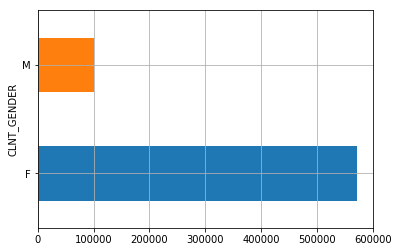

In [9]:
P_GENDER_NUM['NUM'].plot(kind='barh',grid=True)

In [10]:
P_GENDER_NUM.to_csv("GENDER_NUM.csv",mode="w")

GENDER_NUM 테이블을 저장하는 코드.

# 연령대별 빈도

In [11]:
AGE_NUM=spark.sql("""select CLNT_AGE, count(CLNT_AGE) as NUM from Custom group by CLNT_AGE order by CLNT_AGE DESC""")
AGE_NUM.createOrReplaceTempView('GENDER_AGE')
AGE_NUM.show()

+--------+------+
|CLNT_AGE|   NUM|
+--------+------+
|      80|    32|
|      70|   846|
|      60|  5256|
|      50| 36624|
|      40|216217|
|      30|313600|
|      20| 95297|
|      10|  3807|
+--------+------+



AGE_NUM: 기존 Custom 테이블에서 연령대별 고객 수 파악을 위해 추출한 데이터 프레임

In [12]:
P_AGE_NUM=AGE_NUM.toPandas()
P_AGE_NUM.set_index('CLNT_AGE',inplace=True)
P_AGE_NUM

,NUM
CLNT_AGE,
80,32
70,846
60,5256
50,36624
40,216217
30,313600
20,95297
10,3807


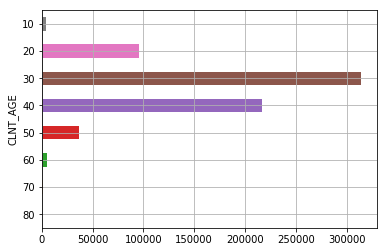

In [13]:
P_AGE_NUM['NUM'].plot(kind='barh',grid=True)

In [14]:
P_AGE_NUM.to_csv("AGE_NUM.csv",mode="w")

# 상품 주요정보

# 구매 개수로 알아보는 고객 선호 브랜드 TOP 10

In [15]:
BRA_BUY_CT=spark.sql("""select PD_BRA_NM, sum(PD_BUY_CT) as BUY_CT from Product group by PD_BRA_NM order by BUY_CT """)
BRA_BUY_CT.createOrReplaceTempView('BRA_BUY_CT')
BRA_BUY_CT.show()

+----------+------+
| PD_BRA_NM|BUY_CT|
+----------+------+
|   1912506|   1.0|
|      [씨루]|   1.0|
|  에디피스(시계)|   1.0|
|    [포나리나]|   1.0|
|   앙드레김 골프|   1.0|
|    [모놀로그]|   1.0|
|       파사디|   1.0|
|갤럭시탭S2 9.7|   1.0|
|     뉴비스옴므|   1.0|
|    [엠케이티]|   1.0|
|    [쎄라피트]|   1.0|
|     [로마로]|   1.0|
|   [제이빈야드]|   1.0|
|     힐링팩토리|   1.0|
|       앤쿠쿠|   1.0|
|      아이센스|   1.0|
|     [오메가]|   1.0|
|     [드림팜]|   1.0|
|      [롤팩]|   1.0|
|    [골프아미]|   1.0|
+----------+------+
only showing top 20 rows



BRA_BUY_CT: 기존 Product 테이블에서 브랜드를 그룹화하여 브랜드별 구매개수를 추출한 데이터프레임

In [16]:
P_BRA_BUY_CT=BRA_BUY_CT.toPandas()
P_BRA_BUY_CT.set_index('PD_BRA_NM',inplace=True)
BRA_TOP10=P_BRA_BUY_CT.tail(10)
BRA_TOP10

,BUY_CT
PD_BRA_NM,
아디다스(의류),26648.0
가쯔,26795.0
입생로랑,27439.0
크록스,31019.0
탑텐,33060.0
에이치커넥트,33923.0
한샘,35576.0
정관장,41691.0
나이키,50588.0


BRA_TOP10: 브랜드별 구매개수 테이블에서 가장 구매량이 많은 TOP10을 추출한 테이블.

In [20]:
BRA_TOP10.to_csv("BRAND_TOP10.csv",mode="w")

In [21]:
BRA_TOP20=P_BRA_BUY_CT.tail(20)

BRA_TOP20: 브랜드별 구매개수 테이블에서 가장 구매량이 많은 TOP20을 추출한 테이블.

In [22]:
BRA_TOP20.to_csv("BRAND_TOP20.csv",mode="w")

# 가장 많이 팔린 상품분류

In [23]:
C_BUY_CT=spark.sql("""select PD_C,sum(PD_BUY_CT) as BUY_CT from Product group by PD_C order by PD_C""")
C_BUY_CT.createOrReplaceTempView('C_BUY_CT')
C_BUY_CT.show()

+------+------+
|  PD_C|BUY_CT|
+------+------+
|000001|   1.0|
|000002|   1.0|
|000003|   4.0|
|000004|   1.0|
|000005|   1.0|
|000006|   1.0|
|000007| 282.0|
|000008|   1.0|
|000009|   1.0|
|000010|   2.0|
|000011|   7.0|
|000012|   1.0|
|000013|   1.0|
|000014|   6.0|
|000015|   1.0|
|000016|   3.0|
|000017|  20.0|
|000018|   3.0|
|000019|   2.0|
|000020|   9.0|
+------+------+
only showing top 20 rows



C_BUY_CT: 기존 Product 테이블에서 제품코드별 구매수량을 추출한 테이블.

In [24]:
CLAC=spark.sql("""select Master.PD_C, CLAC1_NM, CLAC2_NM, CLAC3_NM, BUY_CT from Master inner join C_BUY_CT on Master.PD_C=C_BUY_CT.PD_C order by PD_C""")
CLAC.createOrReplaceTempView('CLAC')
CLAC.show()

+------+---------+--------+----------+------+
|  PD_C| CLAC1_NM|CLAC2_NM|  CLAC3_NM|BUY_CT|
+------+---------+--------+----------+------+
|000001|  식기/조리기구|    조리기구|       압력솥|   1.0|
|000002|     패션잡화|      보석|       목걸이|   1.0|
|000003| 구기/필드스포츠|      골프|    골프연습장비|   4.0|
|000004| 구기/필드스포츠|      골프|    골프연습장비|   1.0|
|000005| 구기/필드스포츠|      골프|    골프연습장비|   1.0|
|000006|     패션잡화|     여성화|     여성펌프스|   1.0|
|000007|    시즌스포츠|  수영/물놀이|     아쿠아슈즈| 282.0|
|000008|       가구|    거실가구|   스툴/리빙의자|   1.0|
|000009|       가구|    거실가구|   스툴/리빙의자|   1.0|
|000010|속옷/양말/홈웨어|    남성속옷|      남성팬티|   2.0|
|000011|  출산/육아용품|  유아발육용품|바운서/쏘서/보행기|   7.0|
|000012|    시즌스포츠|  수영/물놀이|      수영모자|   1.0|
|000013|    시즌스포츠|  수영/물놀이|      수영모자|   1.0|
|000014|  식기/조리기구| 밀폐/보관용기|  반찬통/밀폐용기|   6.0|
|000015|  출산/육아용품|  유아위생용품|    유아용물티슈|   1.0|
|000016|  출산/육아용품|  유아위생용품|    유아용물티슈|   3.0|
|000017|  출산/육아용품|  유아위생용품|    유아용물티슈|  20.0|
|000018|  출산/육아용품|  유아위생용품|    유아용물티슈|   3.0|
|000019|  출산/육아용품|  유아위생용품|    유아용

CLAC: C_BUY_CT 테이블과 Master 테이블의 제품코드를 이용해 테이블을 조인하여 코드별 제품분류와 분류별 구매량을 알 수 있는 테이블을 추출.

In [25]:
CLAC1_BUY_CT=spark.sql("""select CLAC1_NM, sum(BUY_CT) as BUY_COUNT from CLAC group by CLAC1_NM order by BUY_COUNT""")
CLAC1_BUY_CT.createOrReplaceTempView('CLAC1_BUY_CT')
CLAC1_BUY_CT.show()

+--------+---------+
|CLAC1_NM|BUY_COUNT|
+--------+---------+
|   000원"|     15.0|
|   자동차용품|   1369.0|
| 영상/음향가전|   7189.0|
| 냉장/세탁가전|   7620.0|
|    냉장식품|  15009.0|
|    계절가전|  15448.0|
|    냉동식품|  24115.0|
|     축산물|  25826.0|
|     컴퓨터|  26032.0|
| 헬스/피트니스|  27713.0|
|     상품권|  28304.0|
|     모바일|  28556.0|
|      과일|  40213.0|
|구기/필드스포츠|  42739.0|
| 생활/주방가전|  44018.0|
| 아웃도어/레저|  54156.0|
|      가구|  54312.0|
|   세제/위생|  54409.0|
|      완구|  62739.0|
|    주방잡화|  63123.0|
+--------+---------+
only showing top 20 rows



CLAC1_BUY: CLAC 테이블에서 대분류별 그룹화를 통해 구매량을 추출한 테이블

In [26]:
P_CLAC1_BUY_CT=CLAC1_BUY_CT.toPandas()
P_CLAC1_BUY_CT.set_index('CLAC1_NM',inplace=True)
CLAC1_TOP10=P_CLAC1_BUY_CT.tail(10)
CLAC1_TOP10

,BUY_COUNT
CLAC1_NM,
건강식품,168978.0
출산/육아용품,173848.0
퍼스널케어,177126.0
유아동의류,349128.0
패션잡화,468806.0
속옷/양말/홈웨어,546750.0
남성의류,580496.0
스포츠패션,600924.0
화장품/뷰티케어,670504.0


CLAC1_TOP10: 대분류별 구매량이 가장 많은 TOP10을 추출

In [28]:
CLAC1_TOP10.to_csv("CLAC1_TOP10.csv",mode="w")

In [29]:
CLAC1_TOP20=P_CLAC1_BUY_CT.tail(20)

CLAC1_TOP20: 대분류별 구매량이 가장 많은 TOP20을 추출

In [30]:
CLAC1_TOP20.to_csv("CLAC1_TOP20.csv",mode="w")

# 회원 연령대별 구매 상품 분류

In [31]:
Custom_AGE=spark.sql("""select Custom.CLNT_ID, PD_C,CLNT_AGE from Product inner join Custom on Product.CLNT_ID=Custom.CLNT_ID order by CLNT_ID""")
Custom_AGE.createOrReplaceTempView('Custom_AGE')
Custom_AGE.show()

+-------+------+--------+
|CLNT_ID|  PD_C|CLNT_AGE|
+-------+------+--------+
|0000008|206218|      20|
|0000008|206218|      20|
|0000014|369141|      30|
|0000014|645262|      30|
|0000032|048881|      40|
|0000032|031982|      40|
|0000032|031974|      40|
|0000032|038697|      40|
|0000032|048881|      40|
|0000056|425529|      40|
|0000056|425529|      40|
|0000056|824386|      40|
|0000058|146452|      30|
|0000058|243342|      30|
|0000058|417290|      30|
|0000058|146435|      30|
|0000058|146452|      30|
|0000058|420859|      30|
|0000059|780899|      40|
|0000059|780894|      40|
+-------+------+--------+
only showing top 20 rows



Custom_AGE: 회원 연령대별 구매상품을 알기 위해 Product 테이블과 Custom 테이블을 CLNT_ID 기준으로 조인한 테이블. 
    
고객id별 구매 제품코드와 나이정보를 알 수 있음.

In [32]:
AGE_CLAC=spark.sql("""select CLNT_AGE, CLAC1_NM from Custom_AGE inner join Master on Custom_AGE.PD_C=Master.PD_C order by CLAC1_NM""")
AGE_CLAC.createOrReplaceTempView('AGE_CLAC')
AGE_CLAC.show()

+--------+--------+
|CLNT_AGE|CLAC1_NM|
+--------+--------+
|      30|   000원"|
|      30|   000원"|
|      30|   000원"|
|      30|   000원"|
|      40|   000원"|
|      40|   000원"|
|      20|   000원"|
|      30|   000원"|
|      20|   000원"|
|      30|   000원"|
|      30|   000원"|
|      20|   000원"|
|      40|   000원"|
|      30|   000원"|
|      40|      가구|
|      40|      가구|
|      30|      가구|
|      40|      가구|
|      30|      가구|
|      40|      가구|
+--------+--------+
only showing top 20 rows



AGE_CLAC: Master 테이블과 Custom 테이블을 제품 코드를 이용해 join하여 고객 나이에 따른 구매 제품 대분류를 추출한 테이블

# 10, 20대 선호 카테고리 TOP10

In [33]:
AGE_CLAC_1020=spark.sql("""select * from AGE_CLAC where CLNT_AGE=10 or CLNT_AGE=20""")
AGE_CLAC_1020.createOrReplaceTempView('AGE_CLAC_1020')
AGE_CLAC_1020.show()

+--------+--------+
|CLNT_AGE|CLAC1_NM|
+--------+--------+
|      20|   000원"|
|      20|   000원"|
|      20|   000원"|
|      20|      가구|
|      20|      가구|
|      20|      가구|
|      20|      가구|
|      20|      가구|
|      20|      가구|
|      20|      가구|
|      20|      가구|
|      20|      가구|
|      20|      가구|
|      20|      가구|
|      20|      가구|
|      20|      가구|
|      20|      가구|
|      20|      가구|
|      20|      가구|
|      20|      가구|
+--------+--------+
only showing top 20 rows



AGE_CLAC_1020: AGE_CLAC 테이블에서 나이가 10대, 20대인 고객만 추출한 테이블

In [34]:
AGE_CLAC_1020_2=spark.sql("""select CLAC1_NM, count(CLAC1_NM) as BUY_CT from AGE_CLAC_1020 group by CLAC1_NM order by BUY_CT""")
AGE_CLAC_1020_2.createOrReplaceTempView('AGE_CLAC_1020_2')
AGE_CLAC_1020_2.show()

+----------+------+
|  CLAC1_NM|BUY_CT|
+----------+------+
|     000원"|     3|
|     자동차용품|    96|
|   냉장/세탁가전|   275|
|   인테리어/조명|   360|
|   영상/음향가전|   474|
|      냉장식품|   584|
|      계절가전|   757|
|      냉동식품|   925|
|        과일|  1088|
|  구기/필드스포츠|  1128|
|       축산물|  1185|
|      주방잡화|  1671|
|        완구|  1706|
|       컴퓨터|  1818|
|       상품권|  1888|
|   아웃도어/레저|  1934|
|   문구/사무용품|  1970|
|     세제/위생|  2311|
|   헬스/피트니스|  2484|
|청소/세탁/욕실용품|  2533|
+----------+------+
only showing top 20 rows



AGE_CLAC_1020_2: 10,20대 고객으로만 이루어진 대분류 테이블에서 분류별 구매수량을 뽑아낸 테이블.

In [35]:
P_AGE_CLAC_1020_2=AGE_CLAC_1020_2.toPandas()
P_AGE_CLAC_1020_2.set_index('CLAC1_NM',inplace=True)
CLAC1_1020_TOP10=P_AGE_CLAC_1020_2.tail(10)
CLAC1_1020_TOP10

,BUY_CT
CLAC1_NM,
건강식품,8317
시즌스포츠,8481
원예/애완,10248
퍼스널케어,11181
속옷/양말/홈웨어,27065
남성의류,34192
여성의류,34649
패션잡화,38317
스포츠패션,46543


CLAC1_1020_TOP10: AGE_CLAC_1020_2 테이블을 이용해 10, 20대가 가장 많이 구매한 제품 대분류 TOP10을 추출한 테이블.

In [37]:
CLAC1_1020_TOP10.to_csv("CLAC1_1020_TOP10.csv",mode="w")

# 30, 40대 선호 카테고리 TOP10

In [38]:
AGE_CLAC_3040=spark.sql("""select * from AGE_CLAC where CLNT_AGE=30 or CLNT_AGE=40""")
AGE_CLAC_3040.createOrReplaceTempView('AGE_CLAC_3040')
AGE_CLAC_3040.show()

+--------+--------+
|CLNT_AGE|CLAC1_NM|
+--------+--------+
|      30|   000원"|
|      30|   000원"|
|      30|   000원"|
|      30|   000원"|
|      40|   000원"|
|      30|   000원"|
|      40|   000원"|
|      30|   000원"|
|      30|   000원"|
|      40|   000원"|
|      30|   000원"|
|      40|      가구|
|      40|      가구|
|      40|      가구|
|      30|      가구|
|      30|      가구|
|      30|      가구|
|      30|      가구|
|      30|      가구|
|      30|      가구|
+--------+--------+
only showing top 20 rows



AGE_CLAC_3040: AGE_CLAC 테이블에서 나이가 30대, 40대인 고객만 추출한 테이블

In [41]:
AGE_CLAC_3040_2=spark.sql("""select CLAC1_NM, count(CLAC1_NM) as BUY_CT from AGE_CLAC_3040 group by CLAC1_NM order by BUY_CT""")
AGE_CLAC_3040_2.createOrReplaceTempView('AGE_CLAC_3040_2')
AGE_CLAC_3040_2.show()

+----------+------+
|  CLAC1_NM|BUY_CT|
+----------+------+
|     000원"|    11|
|     자동차용품|   809|
|   영상/음향가전|  3011|
|   냉장/세탁가전|  4005|
|   인테리어/조명|  4776|
|       축산물|  5730|
|       상품권|  7971|
|      냉동식품|  8266|
|      냉장식품|  8451|
|      계절가전|  8744|
|       컴퓨터| 11888|
|        과일| 13933|
|       모바일| 14381|
|   헬스/피트니스| 16474|
|  구기/필드스포츠| 20589|
|   생활/주방가전| 26961|
|        가구| 28027|
|   아웃도어/레저| 29236|
|청소/세탁/욕실용품| 29277|
|     세제/위생| 29710|
+----------+------+
only showing top 20 rows



AGE_CLAC_3040_2: 30,40대 고객으로만 이루어진 대분류 테이블에서 분류별 구매수량을 뽑아낸 테이블.

In [42]:
P_AGE_CLAC_3040_2=AGE_CLAC_3040_2.toPandas()
P_AGE_CLAC_3040_2.set_index('CLAC1_NM',inplace=True)
CLAC1_3040_TOP10=P_AGE_CLAC_3040_2.tail(10)
CLAC1_3040_TOP10

,BUY_CT
CLAC1_NM,
퍼스널케어,86583
시즌스포츠,110043
출산/육아용품,111243
유아동의류,274905
속옷/양말/홈웨어,284158
패션잡화,305120
화장품/뷰티케어,344663
남성의류,345143
스포츠패션,362451


CLAC1_3040_TOP10: AGE_CLAC_3040_2 테이블을 이용해 30, 40대가 가장 많이 구매한 제품 대분류 TOP10을 추출한 테이블.

In [43]:
CLAC1_3040_TOP10.to_csv("CLAC1_3040_TOP10.csv",mode="w")

# 50, 60대 선호 카테고리 TOP10

In [44]:
AGE_CLAC_5060=spark.sql("""select * from AGE_CLAC where CLNT_AGE=50 or CLNT_AGE=60""")
AGE_CLAC_5060.createOrReplaceTempView('AGE_CLAC_5060')
AGE_CLAC_5060.show()

+--------+--------+
|CLNT_AGE|CLAC1_NM|
+--------+--------+
|      50|      가구|
|      50|      가구|
|      50|      가구|
|      50|      가구|
|      50|      가구|
|      50|      가구|
|      50|      가구|
|      50|      가구|
|      50|      가구|
|      50|      가구|
|      50|      가구|
|      50|      가구|
|      50|      가구|
|      50|      가구|
|      50|      가구|
|      50|      가구|
|      50|      가구|
|      50|      가구|
|      50|      가구|
|      50|      가구|
+--------+--------+
only showing top 20 rows



AGE_CLAC_5060: AGE_CLAC 테이블에서 나이가 50대, 60대인 고객만 추출한 테이블

In [45]:
AGE_CLAC_5060_2=spark.sql("""select CLAC1_NM, count(CLAC1_NM) as BUY_CT from AGE_CLAC_5060 group by CLAC1_NM order by BUY_CT""")
AGE_CLAC_5060_2.createOrReplaceTempView('AGE_CLAC_5060_2')
AGE_CLAC_5060_2.show()

+----------+------+
|  CLAC1_NM|BUY_CT|
+----------+------+
|     자동차용품|    73|
|   영상/음향가전|   293|
|       상품권|   446|
|   인테리어/조명|   463|
|   냉장/세탁가전|   543|
|       축산물|   626|
|        완구|   811|
|      냉동식품|   975|
|       모바일|  1177|
|      계절가전|  1273|
|       컴퓨터|  1296|
|   헬스/피트니스|  1515|
|      냉장식품|  1740|
|   출산/육아용품|  2018|
|        과일|  2708|
|   문구/사무용품|  2730|
|   생활/주방가전|  2914|
|        가구|  2924|
|     세제/위생|  2924|
|청소/세탁/욕실용품|  2986|
+----------+------+
only showing top 20 rows



AGE_CLAC_5060_2: 50,60대 고객으로만 이루어진 대분류 테이블에서 분류별 구매수량을 뽑아낸 테이블.

In [46]:
P_AGE_CLAC_5060_2=AGE_CLAC_5060_2.toPandas()
P_AGE_CLAC_5060_2.set_index('CLAC1_NM',inplace=True)
CLAC1_5060_TOP10=P_AGE_CLAC_5060_2.tail(10)
CLAC1_5060_TOP10

,BUY_CT
CLAC1_NM,
식기/조리기구,7155
퍼스널케어,7634
원예/애완,8336
건강식품,9777
속옷/양말/홈웨어,19422
화장품/뷰티케어,26442
패션잡화,28448
남성의류,31365
스포츠패션,34163


CLAC1_5060_TOP10: AGE_CLAC_5060_2 테이블을 이용해 50, 60대가 가장 많이 구매한 제품 대분류 TOP10을 추출한 테이블.

In [47]:
CLAC1_5060_TOP10.to_csv("CLAC1_5060_TOP10.csv",mode="w")

# 70, 80대 선호 카테고리 TOP10

In [48]:
AGE_CLAC_7080=spark.sql("""select * from AGE_CLAC where CLNT_AGE=70 or CLNT_AGE=80""")
AGE_CLAC_7080.createOrReplaceTempView('AGE_CLAC_7080')
AGE_CLAC_7080.show()

+--------+--------+
|CLNT_AGE|CLAC1_NM|
+--------+--------+
|      70|      가구|
|      70|      가구|
|      70|      가구|
|      70|      가구|
|      70|      가구|
|      70|      가구|
|      70|      가구|
|      70|      가구|
|      70|      가구|
|      70|      가구|
|      70|      가구|
|      70|      가구|
|      70|      가구|
|      70|      가구|
|      70|      가구|
|      70|      가구|
|      70|      가구|
|      70|      가구|
|      70|      가구|
|      70|      가구|
+--------+--------+
only showing top 20 rows



AGE_CLAC_7080: AGE_CLAC 테이블에서 나이가 70대, 80대인 고객만 추출한 테이블

In [49]:
AGE_CLAC_7080_2=spark.sql("""select CLAC1_NM, count(CLAC1_NM) as BUY_CT from AGE_CLAC_7080 group by CLAC1_NM order by BUY_CT""")
AGE_CLAC_7080_2.createOrReplaceTempView('AGE_CLAC_7080_2')
AGE_CLAC_7080_2.show()

+----------+------+
|  CLAC1_NM|BUY_CT|
+----------+------+
|     자동차용품|     1|
|   영상/음향가전|     9|
|   인테리어/조명|     9|
|   냉장/세탁가전|    11|
|      냉동식품|    16|
|   헬스/피트니스|    18|
|       상품권|    19|
|      계절가전|    21|
|       모바일|    28|
|       컴퓨터|    28|
|      냉장식품|    31|
|       축산물|    34|
|   문구/사무용품|    34|
|   출산/육아용품|    40|
|        완구|    40|
|   식기/조리기구|    41|
|        가구|    48|
|   생활/주방가전|    49|
|     침구/수예|    50|
|청소/세탁/욕실용품|    53|
+----------+------+
only showing top 20 rows



AGE_CLAC_7080_2: 70, 80대 고객으로만 이루어진 대분류 테이블에서 분류별 구매수량을 뽑아낸 테이블.

In [50]:
P_AGE_CLAC_7080_2=AGE_CLAC_7080_2.toPandas()
P_AGE_CLAC_7080_2.set_index('CLAC1_NM',inplace=True)
CLAC1_7080_TOP10=P_AGE_CLAC_7080_2.tail(10)
CLAC1_7080_TOP10

,BUY_CT
CLAC1_NM,
퍼스널케어,146
건강식품,158
원예/애완,187
유아동의류,293
패션잡화,435
속옷/양말/홈웨어,444
화장품/뷰티케어,553
남성의류,707
여성의류,810


CLAC1_7080_TOP10: AGE_CLAC_7080_2 테이블을 이용해 70, 80대가 가장 많이 구매한 제품 대분류 TOP10을 추출한 테이블.

In [52]:
CLAC1_7080_TOP10.to_csv("CLAC1_7080_TOP10.csv",mode="w")

# 고객 특성별 사용기기 정보

#### Custom_Gender: 고객 성별 테이블, Custom_Age: 고객 연령 테이블, Custom_DVC: 고객 사용기기 테이블

In [54]:
Custom_Gender=spark.sql("""select DISTINCT C.CLNT_ID as ID, C.CLNT_GENDER as gender from Custom as C ORDER BY ID""")
Custom_Age=spark.sql("""select DISTINCT C.CLNT_ID as ID, C.CLNT_AGE as age from Custom as C ORDER BY ID""")
Custom_DVC=spark.sql("""select DISTINCT S.CLNT_ID as ID, S.DVC_CTG_NM as DVC from Session as S ORDER BY ID""")
Custom_Gender.createOrReplaceTempView("Custom_Gender")
Custom_Age.createOrReplaceTempView("Custom_Age")
Custom_DVC.createOrReplaceTempView("Custom_DVC")
Custom_Gender.show()
Custom_Age.show()
Custom_DVC.show()

+-------+------+
|     ID|gender|
+-------+------+
|0000008|     M|
|0000014|     F|
|0000032|     M|
|0000056|     F|
|0000058|     F|
|0000059|     F|
|0000063|     F|
|0000064|     F|
|0000068|     F|
|0000071|     F|
|0000073|     M|
|0000078|     F|
|0000089|     F|
|0000093|     M|
|0000104|     F|
|0000106|     F|
|0000114|     F|
|0000121|     F|
|0000129|     F|
|0000135|     M|
+-------+------+
only showing top 20 rows

+-------+---+
|     ID|age|
+-------+---+
|0000008| 20|
|0000014| 30|
|0000032| 40|
|0000056| 40|
|0000058| 30|
|0000059| 40|
|0000063| 40|
|0000064| 40|
|0000068| 30|
|0000071| 40|
|0000073| 40|
|0000078| 30|
|0000089| 30|
|0000093| 40|
|0000104| 40|
|0000106| 40|
|0000114| 20|
|0000121| 30|
|0000129| 30|
|0000135| 40|
+-------+---+
only showing top 20 rows

+-------+-------+
|     ID|    DVC|
+-------+-------+
|0000008| mobile|
|0000014| mobile|
|0000025|desktop|
|0000032| mobile|
|0000033|desktop|
|0000051|desktop|
|0000056| mobile|
|0000058| mobile|
|00000

#### DVC_Num: 기기별 사용량

In [55]:
DVC_Num=spark.sql("""select DVC, count(DVC) from Custom_DVC group by DVC""")

# 성별 분석

### 고객성별 사용기기 정보를 분석하기 위해 Custom_Gender 테이블과 Custom_DVC 테이블을 조인
#### Custom_DVC 테이블에는 있지만 Custom_Gender 테이블에는 없는 고객 정보는 의미가 없으므로 제외하여 분석

In [56]:
GD_inner=spark.sql("""select G.ID, gender, DVC from Custom_Gender as G inner join Custom_DVC as D on G.ID=D.ID ORDER BY G.ID""")
GD_inner.createOrReplaceTempView("GD_inner")
GD_inner.show()

+-------+------+------+
|     ID|gender|   DVC|
+-------+------+------+
|0000008|     M|mobile|
|0000014|     F|mobile|
|0000032|     M|mobile|
|0000056|     F|mobile|
|0000058|     F|mobile|
|0000059|     F|mobile|
|0000063|     F|mobile|
|0000064|     F|mobile|
|0000068|     F|mobile|
|0000071|     F|mobile|
|0000073|     M|mobile|
|0000078|     F|mobile|
|0000089|     F|mobile|
|0000093|     M|mobile|
|0000104|     F|mobile|
|0000106|     F|mobile|
|0000114|     F|mobile|
|0000121|     F|mobile|
|0000129|     F|mobile|
|0000135|     M|mobile|
+-------+------+------+
only showing top 20 rows



GD_inner: 고객 성별 사용 기기정보를 추출한 테이블

### 성별로 구분하여 사용기기를 그룹화하기 위해 성별 테이블을 각각 생성

In [58]:
Man=spark.sql("""select * from GD_inner where gender='M'""")
Man.createOrReplaceTempView("Man")
Man.show()
Woman=spark.sql("""select * from GD_inner where gender='F'""")
Woman.createOrReplaceTempView("Woman")
Woman.show()

+-------+------+------+
|     ID|gender|   DVC|
+-------+------+------+
|0000008|     M|mobile|
|0000032|     M|mobile|
|0000073|     M|mobile|
|0000093|     M|mobile|
|0000135|     M|mobile|
|0000215|     M|mobile|
|0000230|     M|mobile|
|0000252|     M|mobile|
|0000291|     M|mobile|
|0000305|     M|mobile|
|0000524|     M|mobile|
|0000536|     M|mobile|
|0000662|     M|mobile|
|0000749|     M|mobile|
|0000780|     M|mobile|
|0000812|     M|mobile|
|0000823|     M|mobile|
|0000898|     M|mobile|
|0000918|     M|mobile|
|0000943|     M|mobile|
+-------+------+------+
only showing top 20 rows

+-------+------+------+
|     ID|gender|   DVC|
+-------+------+------+
|0000014|     F|mobile|
|0000056|     F|mobile|
|0000058|     F|mobile|
|0000059|     F|mobile|
|0000063|     F|mobile|
|0000064|     F|mobile|
|0000068|     F|mobile|
|0000071|     F|mobile|
|0000078|     F|mobile|
|0000089|     F|mobile|
|0000104|     F|mobile|
|0000106|     F|mobile|
|0000114|     F|mobile|
|0000121|     

Man: 고객 성별 사용기기 테이블에서 남성만 추출한 테이블

Woman: 고객 성별 사용기기 테이블에서 여성만 추출한 테이블

### 성별: 남자 인 경우 사용기기 분포

In [59]:
Man_DVC=spark.sql("""select DVC, count(DVC) as M_DVC_count from Man group by DVC""")
Man_DVC.createOrReplaceTempView("Man_DVC")
Man_DVC.show()

+-------+-----------+
|    DVC|M_DVC_count|
+-------+-----------+
|desktop|         88|
| mobile|     100244|
| tablet|        779|
+-------+-----------+



Man_DVC: 성별이 남자인 경우 기기별 사용량 테이블

In [60]:
P_Man_DVC=Man_DVC.toPandas()
P_Man_DVC.to_csv("Man_DVC.csv",mode="w")

### 성별: 여자 인 경우 사용기기 분포

In [61]:
Woman_DVC=spark.sql("""select DVC, count(DVC) as F_DVC_count from Woman group by DVC""")
Woman_DVC.createOrReplaceTempView("Man_DVC")
Woman_DVC.show()

+-------+-----------+
|    DVC|F_DVC_count|
+-------+-----------+
|desktop|        127|
| mobile|     567719|
| tablet|       2897|
+-------+-----------+



Woman_DVC: 성별이 여자인 경우 기기별 사용량 테이블

In [62]:
P_Woman_DVC=Man_DVC.toPandas()
P_Woman_DVC.to_csv("Woman_DVC.csv",mode="w")

### 데이터 시각화 및 교차표 생성을 위해 pandas 패키지 이용

In [63]:
p_GD_inner=GD_inner.toPandas()

In [64]:
type(p_GD_inner)

pandas.core.frame.DataFrame

In [65]:
p_GD_inner.head()

,ID,gender,DVC
0,0000008,M,mobile
1,0000014,F,mobile
2,0000032,M,mobile
3,0000056,F,mobile
4,0000058,F,mobile


### 성별 사용기기 교차표

In [68]:
GENDER_DEVICE_CROSSTAB=pd.crosstab(p_GD_inner['gender'], p_GD_inner['DVC'])
GENDER_DEVICE_CROSSTAB

DVC,desktop,mobile,tablet
gender,,,
F,127,567719,2897
M,88,100244,779


GENDER_DEVICE_CROSSTAB: 고객 성별정보와 고객별 사용기기정보가 든 테이블을 이용하여 성별 사용기기 교차표를 생성

In [69]:
GENDER_DEVICE_CROSSTAB.to_csv("GENDER_DEVICE_CROSSTAB.csv",mode="w")

# 연령별 분석

### 고객 연령별 사용기기 정보를 분석하기 위해 Custom_Age 테이블과 Custom_DVC 테이블을 조인
#### 성별 분석과 마찬가지로 Custom_DVC 테이블에는 있지만 Custom_Age 테이블에는 없는 고객 정보는 의미가 없으므로 제외하여 분석

In [70]:
Age_Device=spark.sql("""select Custom_Age.ID,age,DVC from Custom_Age inner join Custom_DVC on Custom_Age.ID=Custom_DVC.ID""")
Age_Device.createOrReplaceTempView('Age_Device')
Age_Device.show()

+-------+---+------+
|     ID|age|   DVC|
+-------+---+------+
|0000008| 20|mobile|
|0000014| 30|mobile|
|0000032| 40|mobile|
|0000056| 40|mobile|
|0000058| 30|mobile|
|0000059| 40|mobile|
|0000063| 40|mobile|
|0000064| 40|mobile|
|0000068| 30|mobile|
|0000071| 40|mobile|
|0000073| 40|mobile|
|0000078| 30|mobile|
|0000089| 30|mobile|
|0000093| 40|mobile|
|0000104| 40|mobile|
|0000106| 40|mobile|
|0000114| 20|mobile|
|0000121| 30|mobile|
|0000129| 30|mobile|
|0000135| 40|mobile|
+-------+---+------+
only showing top 20 rows



Age_Device: 고객 연령대별 사용기기를 추출한 테이블

### 연령별 사용기기 교차표

In [72]:
P_Age_Device=Age_Device.toPandas()

In [73]:
AGE_DEVICE_CROSSTAB=pd.crosstab(P_Age_Device['age'],P_Age_Device['DVC'])

AGE_DEVICE_CROSSTAB: 고객 연령대 정보와 고객별 사용기기정보가 든 테이블을 이용하여 연령대별 사용기기 교차표를 생성

In [74]:
AGE_DEVICE_CROSSTAB.to_csv("AGE_DEVICE_CROSSTAB.csv",mode="w")